In [38]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from collections import Counter
from datetime import timedelta
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report

In [2]:
#load both data sets
users = pd.read_csv('takehome_users.csv',encoding='latin-1',parse_dates=True)
engagement = pd.read_csv('takehome_user_engagement.csv',parse_dates=True)

In [3]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
users.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000


In [7]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [5]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [6]:
engagement.describe()

,user_id,visited
count,207917.000000,207917.0
mean,5913.314197,1.0
std,3394.941674,0.0
min,1.000000,1.0
25%,3087.000000,1.0
50%,5682.000000,1.0
75%,8944.000000,1.0
max,12000.000000,1.0


In [8]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [10]:
#set the time_stamp to datetime and the set it as the index
engagement.time_stamp = pd.to_datetime(engagement.time_stamp)
engagement = engagement.set_index('time_stamp', drop= True)

In [17]:
from datetime import timedelta

def label_adopted(x):    
    "takes a users input and returns whether or not they have been active within any 7-day period"
    df_temp = engagement.loc[engagement['user_id'] == x] #select out rows of this user
    df_temp = df_temp.resample('D').mean().dropna() #resample to show if active in a day. .mean() is just of 1
    adopted = 0
    for i in range(len(df_temp)-2): #loop over active days till the second to last day
        if df_temp.index[i + 2] - df_temp.index[i] <= timedelta(days=7): # difference between every 1st and 3rd day
            adopted = 1
            break
        else:
            adopted = 0
    return adopted

In [18]:
users['adopted_user'] = users['object_id'].apply(label_adopted)

In [45]:
users['creation_source'].value_counts()/len(users['object_id'].unique())

ORG_INVITE            0.354500
GUEST_INVITE          0.180250
PERSONAL_PROJECTS     0.175917
SIGNUP                0.173917
SIGNUP_GOOGLE_AUTH    0.115417
Name: creation_source, dtype: float64

In [46]:
print(users[(users['object_id'] == 10741)]['name'] + ' is the user who invited most')

10740    Tennant Piper is the user who invited most
Name: name, dtype: object


In [49]:
# Percentage of users who opted in to mailing list
users['opted_in_to_mailing_list'].value_counts()/ len(users['object_id'].unique())
#Only about 25% of users prefer to receive marketing emails.

0    0.7505
1    0.2495
Name: opted_in_to_mailing_list, dtype: float64

In [48]:
# Percentage of users who are  on   the   regular marketing   email   drip  
users['enabled_for_marketing_drip'].value_counts()/ len(users['object_id'].unique())
#Only 15% of users are on the regular marketing email drip

0    0.850667
1    0.149333
Name: enabled_for_marketing_drip, dtype: float64

In [19]:
print(sum(users['adopted_user']))
print(sum(users.adopted_user)/len(users.adopted_user))

1656
0.138


# Data Visualizations

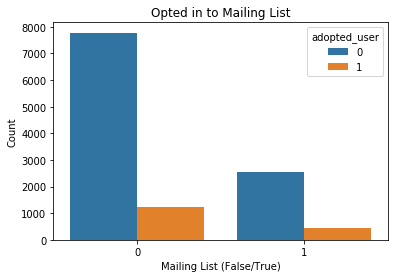

In [51]:
ax = sns.countplot(x="opted_in_to_mailing_list", hue="adopted_user", data=users)
plt.title('Opted in to Mailing List')
plt.xlabel('Mailing List (False/True)')
plt.ylabel('Count')
plt.show()

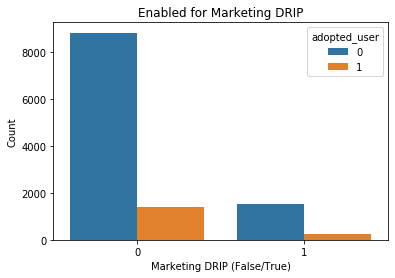

In [53]:
ax = sns.countplot(x="enabled_for_marketing_drip", hue="adopted_user", data=users)
plt.title('Enabled for Marketing DRIP')
plt.xlabel('Marketing DRIP (False/True)')
plt.ylabel('Count')
plt.show()

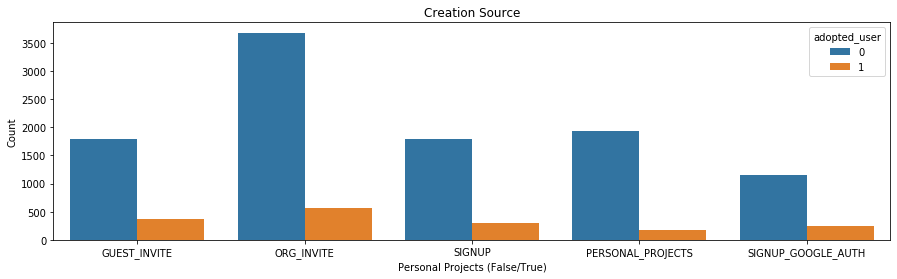

In [64]:
plt.figure(figsize=(15,4))
ax = sns.countplot(x="creation_source", hue="adopted_user", data=users)
plt.title('Creation Source')
plt.xlabel('Personal Projects (False/True)')
plt.ylabel('Count')
plt.show()

adopted vs. not adopted are consistent when comparing the two groups. There are far less adopted users 

# Data analysis 

In [20]:
# set creation_time
users.creation_time = pd.to_datetime(users.creation_time)
#map to convert to datetime
users['last_session_creation_time'] = users['last_session_creation_time'].map(lambda data: 
                                    datetime.datetime.fromtimestamp(int(data)).strftime('%Y-%m-%d %H:%M:%S'),
                                                                              na_action='ignore')

In [21]:
#set that to datetime
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'])
#subtract to find time active
users['usage_length'] = users['last_session_creation_time'] - users['creation_time']
users['usage_length'] = [x.total_seconds() for x in users['usage_length']]

In [22]:
users['email_provider'] = [x.split('@')[1] for x in users.email]
top_emails = users.email_provider.value_counts().index[:6]
#labeling anything not in the top 5 as other
users['email_provider'] = [x if x in top_emails else 'other' for x in users.email_provider]

In [31]:
users.invited_by_user_id = users.invited_by_user_id.fillna(0)

In [32]:
feature_df = users.iloc[:,4:]
feature_df = feature_df.drop('last_session_creation_time', axis=1)
feature_df['usage_length'] = feature_df['usage_length'].fillna(0)

In [33]:
from sklearn.preprocessing import LabelEncoder

gle = LabelEncoder()
creation_labels = gle.fit_transform(users['creation_source'])
feature_df.creation_source = creation_labels

org_id_labels = gle.fit_transform(users['org_id'])
feature_df.org_id = org_id_labels

invited_labels = gle.fit_transform(users['invited_by_user_id'])
feature_df.org_id = invited_labels

email_labels = gle.fit_transform(users['email_provider'])
feature_df.email_provider = email_labels

In [34]:
feature_df.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,usage_length,email_provider
0,0,1,0,2325,10803.0,0,-25200.0,6
1,1,0,0,56,316.0,1,11725200.0,2
2,1,0,0,298,1525.0,0,-25200.0,2
3,0,0,0,1104,5151.0,0,61200.0,6
4,0,0,0,1127,5240.0,0,403200.0,6


# Model 

# Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven­day period, identify which factors predict future user adoption.

## Lets compare a couple different models to see which one is most accurate. 

In [35]:
data = feature_df.drop('adopted_user', axis=1)
labels = feature_df.adopted_user
#split data
X_train, y_train, X_test, y_test = train_test_split(data, labels, test_size=0.33, random_state=42)

In [36]:
#train and test classifier
rf = RandomForestClassifier(class_weight='balanced_subsample')

rf.fit(X_train, X_test)

rf.score(y_train, y_test)

/Users/ChrisM/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9696969696969697

In [39]:
y_pred = rf.predict(y_train)

print(classification_report(y_test, y_pred))

cm= confusion_matrix(y_test,y_pred)
print('confusion matrix:')
print(cm)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3407
           1       0.91      0.87      0.89       553

    accuracy                           0.97      3960
   macro avg       0.94      0.93      0.94      3960
weighted avg       0.97      0.97      0.97      3960

confusion matrix:
[[3359   48]
 [  72  481]]


In [41]:
#Decision Tree Classifier model
dtc = DecisionTreeClassifier()

dtc.fit(X_train, X_test)

dtc.score(y_train, y_test)

0.9618686868686869

In [44]:
#Logistic Regression model
LR = LogisticRegression(class_weight='balanced')

LR.fit(X_train, X_test)

LR.score(y_train, y_test)

/Users/ChrisM/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8146464646464646

## Random Forest gave us the highest accuracy out of the three. Now lets look at features in our random forest model



In [65]:
feature_importance = pd.DataFrame()
feature_importance['coef'] = rf.feature_importances_
feature_importance = feature_importance.set_index(data.columns)
feature_importance.coef.nlargest(10)

usage_length                  0.925360
invited_by_user_id            0.022192
org_id                        0.021697
email_provider                0.012915
creation_source               0.011443
enabled_for_marketing_drip    0.003437
opted_in_to_mailing_list      0.002956
Name: coef, dtype: float64

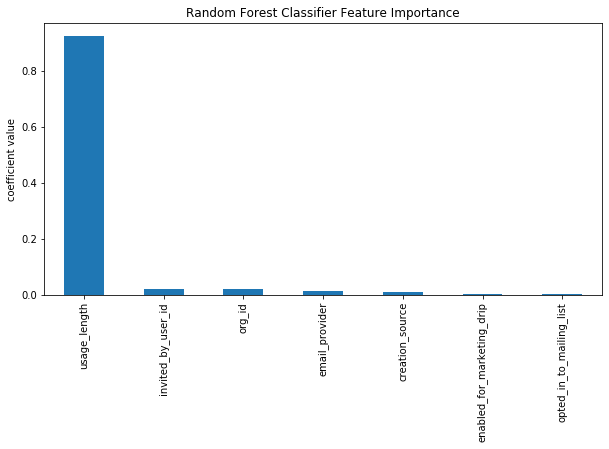

In [66]:
#plot features
plt.figure(figsize=(10,5))
(feature_importance['coef']).nlargest(10).plot(kind='bar', x=feature_importance.index)
plt.title('Random Forest Classifier Feature Importance')
plt.ylabel('coefficient value')
plt.show()


## Usage length was our main feature by a long way. 

## how long between when a user signed up and when their last active session is the greatest indicator of whether or not they became an adopted user